# The Test set

##### Keywords: empirical risk minimization, Hoeffding's inequality, hypothesis space,  training error, out-of-sample error, testing set, training set, test error, complexity parameter

## Contents
{:.no_toc}
*  
{: toc}

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
def make_simple_plot():
    fig, axes=plt.subplots(figsize=(12,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$y$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([-2,2])
    axes[1].set_ylim([-2,2])
    plt.tight_layout();
    return axes
def make_plot():
    fig, axes=plt.subplots(figsize=(20,8), nrows=1, ncols=2);
    axes[0].set_ylabel("$p_R$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    axes[0].set_xlim([0,1])
    axes[1].set_xlim([0,1])
    plt.tight_layout();
    return axes

## Revisiting the model

Let $x$ be the fraction of religious people in a county and $y$ be the probability of voting for Romney as a function of $x$. In other words $y_i$ is data that pollsters have taken which tells us their estimate of people voting for Romney and $x_i$ is the fraction of religious people in county $i$. Because poll samples are finite, there is a margin of error on each data point or county $i$, but we will ignore that for now.

Let us assume that we have a "population" of 200 counties $x$:

In [3]:
dffull=pd.read_csv("data/religion.csv")
dffull.head()

,promney,rfrac
0,0.047790,0.00
1,0.051199,0.01
2,0.054799,0.02
3,0.058596,0.03
4,0.062597,0.04


Lets suppose now that the Lord came by and told us that the points in the plot below captures $f(x)$ exactly. 

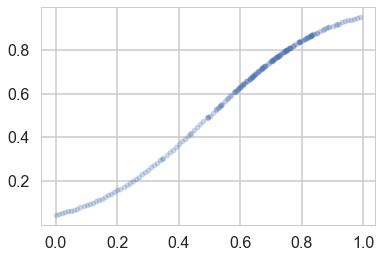

In [4]:
x=dffull.rfrac.values
f=dffull.promney.values
plt.plot(x,f,'.', alpha=0.3)

Notice that our sampling of $x$ is not quite uniform: there are more points around $x$ of 0.7.

Now, in real life we are only given a sample of points. Lets assume that out of this population of 200 points we are given a sample $\cal{D}$ of 30 data points. Such data is called **in-sample data**. Contrastingly, the entire population of data points is also called **out-of-sample data**.

In [5]:
df = pd.read_csv("data/noisysample.csv")
df.head()

,f,i,x,y
0,0.075881,7,0.07,0.138973
1,0.085865,9,0.09,0.050510
2,0.096800,11,0.11,0.183821
3,0.184060,23,0.23,0.057621
4,0.285470,33,0.33,0.358174


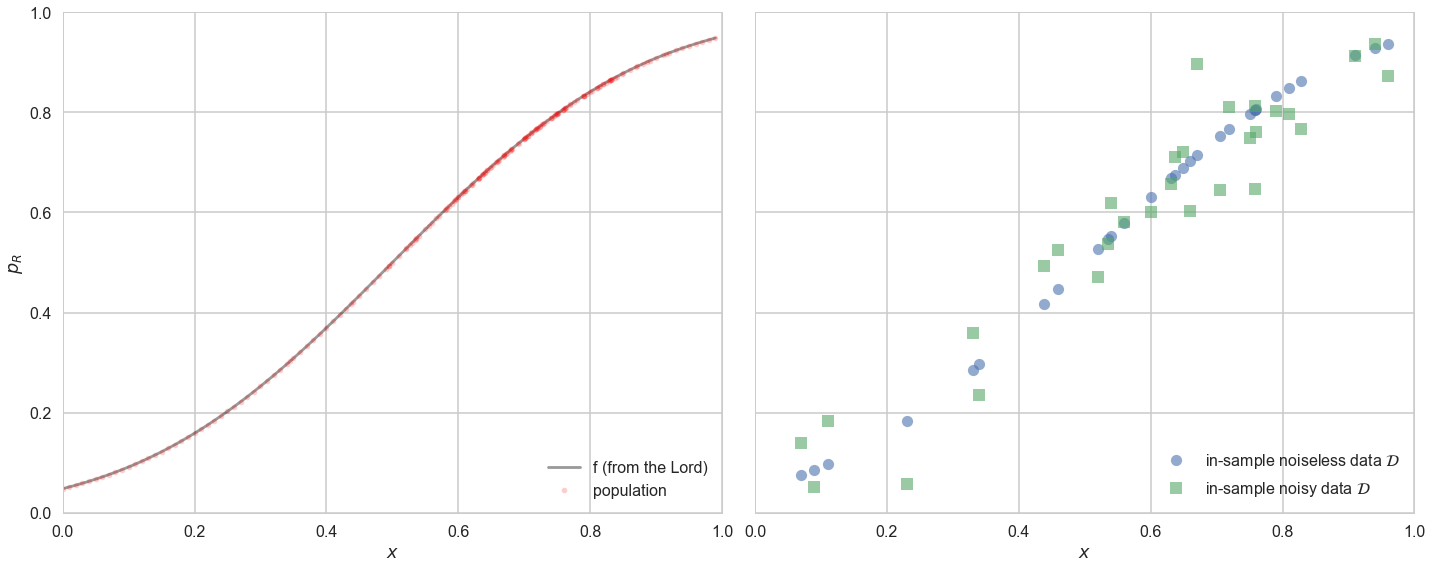

In [6]:
axes=make_plot()
axes[0].plot(x,f, 'k-', alpha=0.4, label="f (from the Lord)");
axes[0].plot(x,f, 'r.', alpha=0.2, label="population");
axes[1].plot(df.x,df.f, 'o', alpha=0.6, label="in-sample noiseless data $\cal{D}$");
axes[1].plot(df.x,df.y, 's', alpha=0.6, label="in-sample noisy data $\cal{D}$");
axes[0].legend(loc=4);
axes[1].legend(loc=4);

## Testing and Training Sets

The process of learning has two parts:

1. Fit for a model by minimizing the in-sample risk
2. Hope that the in-sample risk approximates the out-of-sample risk well.

Mathematically, we are saying that:

$$
\begin{eqnarray*}
A &:& R_{\cal{D}}(g) \,\,smallest\,on\,\cal{H}\\
B &:& R_{out \,of \,sample} (g) \approx R_{\cal{D}}(g)
\end{eqnarray*}
$$

Hoping does not befit us as scientists. How can we test that the in-sample risk approximates the out-of-sample risk well?

The "aha" moment comes when we realize that we can hold back some of our sample, and test the performance of our learner by trying it out on this held back part! Perhaps we can compute the error or risk on the held-out part, or "test" part of our sample, and have something to say about the out-of-sample error.

Let us introduce some new terminology. We take the sample of data $\cal{D}$ that we have been given (our in-sample set) and split it into two parts:

1. The **training set**, which is the part of the data we use to fit a model
2. The **testing set**, a smaller part of the data set which we use to see how good our fit was.

This split is done by choosing points at random into these two sets. Typically we might take 80% of our data and put it in the training set, with the remaining amount going into the test set. This can be carried out in python using the `train_test_split` function from `sklearn.cross_validation`.

The split is shown in the diagram below:

![m:caption](images/train-test.png)

We ARE taking a hit on the amount of data we have to train our model. The more data we have, the better we can do for our fits. But, you cannot figure out the generalization ability of a learner by looking at the same data it was trained on: there is nothing to generalize to, and as we know we can fit very complex models to training data which have no hope of generalizing (like an interpolator). Thus, to estimate the **out-of-sample error or risk**, we must leave data over to make this estimation. 

At this point you are thinking: the test set is just another sample of the population, just like the training set. What guarantee do we have that it approximates the out-of-sample error well? And furthermore, if we pick 6 out of 30 points as a test set, why would you expect the estimate to be any good?

We will kind-of hand wavingly show later that the test set error is a good estimate of the out of sample error, especially for larger and larger test sets. You are right to worry that 6 points is perhaps too few, but thats what we have for now, and we shall work with them.

We are **using the training set then, as our in-sample set, and the test set as a proxy for out-of-sample.**.

In [7]:
from sklearn.cross_validation import train_test_split
datasize=df.shape[0]
#split dataset using the index, as we have x,f, and y that we want to split.
itrain,itest = train_test_split(range(30),train_size=24, test_size=6)
xtrain= df.x[itrain].values
ftrain = df.f[itrain].values
ytrain = df.y[itrain].values
xtest= df.x[itest].values
ftest = df.f[itest].values
ytest = df.y[itest].values

//anaconda/envs/py3l/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


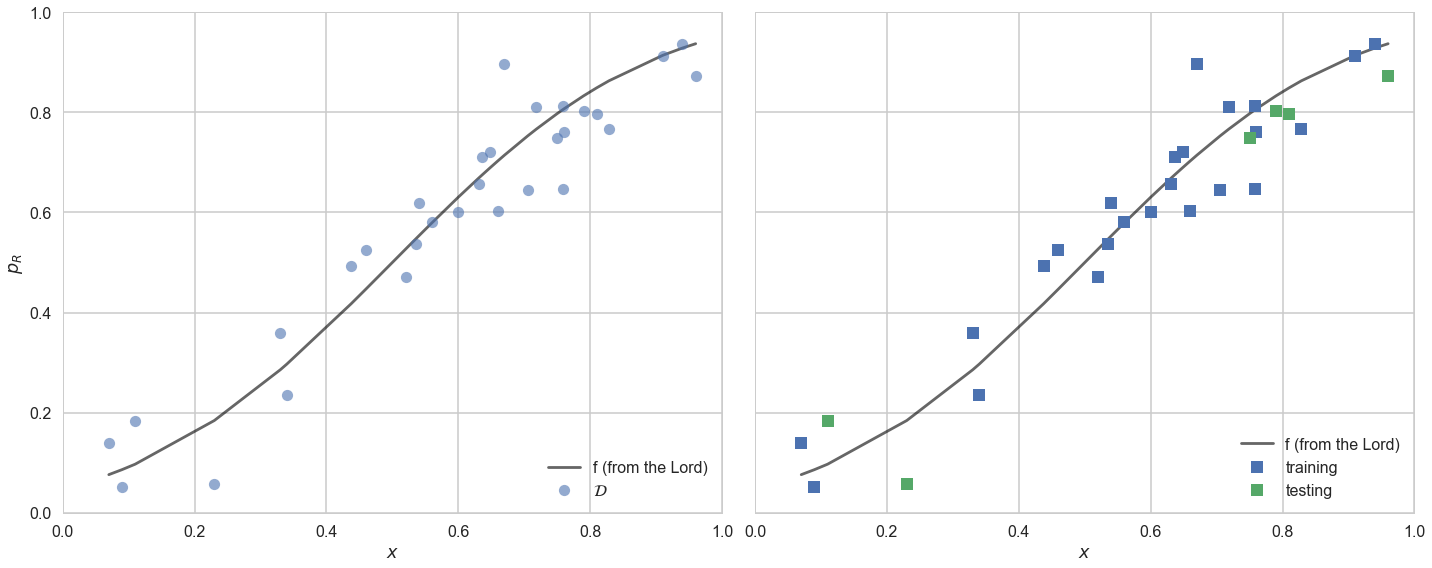

In [8]:
axes=make_plot()
axes[0].plot(df.x,df.f, 'k-', alpha=0.6, label="f (from the Lord)");
axes[0].plot(df.x,df.y, 'o',alpha=0.6, label="$\cal{D}$");
axes[1].plot(df.x,df.f, 'k-', alpha=0.6, label="f (from the Lord)");
axes[1].plot(xtrain, ytrain, 's', label="training")
axes[1].plot(xtest, ytest, 's', label="testing")
axes[0].legend(loc="lower right")
axes[1].legend(loc="lower right")

## A digression about scikit-learn

Scikit-learn is the main python machine learning library. It consists of many learners which can learn models from data, as well as a lot of utility functions such as `train_test_split`. It can be used in python by the incantation `import sklearn`.

The library has a very well defined interface. This makes the library a joy to use, and surely contributes to its popularity. As the [scikit-learn API paper](http://arxiv.org/pdf/1309.0238v1.pdf) [Buitinck, Lars, et al. "API design for machine learning software: experiences from the scikit-learn project." arXiv preprint arXiv:1309.0238 (2013).] says:

>All objects within scikit-learn share a uniform common basic API consisting of three complementary interfaces: **an estimator interface for building and ﬁtting models, a predictor interface for making predictions and a transformer interface for converting data**. The estimator interface is at the core of the library. It deﬁnes instantiation mechanisms of objects and exposes a `fit` method for learning a model from training data. All supervised and unsupervised learning algorithms (e.g., for classiﬁcation, regression or clustering) are oﬀered as objects implementing this interface. Machine learning tasks like feature extraction, feature selection or dimensionality reduction are also provided as estimators.

Earlier we fit `y` using the python function `polyfit`. To get you familiarized with scikit-learn, we'll use the "estimator" interface here, specifically the estimator `PolynomialFeatures`. The API paper again:

>Since it is common to modify or ﬁlter data before feeding it to a learning algorithm, some estimators in the library implement a transformer interface which deﬁnes a transform method. It takes as input some new data X and yields as output a transformed version of X. Preprocessing, feature selection, feature extraction and dimensionality reduction algorithms are all provided as transformers within the library.

To start with we have one **feature** `x`, the fraction of religious people in a county, which we want to use to predict `y`, the fraction of people voting for Romney in that county. What we will do is the transformation:

$$ x \rightarrow 1, x, x^2, x^3, ..., x^d $$

for some power $d$. Our job then is to **fit** for the coefficients of these features in the polynomial

$$ a_0 + a_1 x + a_2 x^2 + ... + a_d x^d. $$

### Transformers in  sklearn

In other words, we have transformed a function of one feature, into a (rather simple) **linear** function of many features. To do this we first construct the estimator as `PolynomialFeatures(d)`, and then transform these features into a d-dimensional space using the method `fit_transform`.

![fit_transform](images/sklearntrans.jpg)

Here is an example. The reason for using `[[1],[2],[3]]` as opposed to `[1,2,3]` is that scikit-learn expects data to be stored in a two-dimensional array or matrix with size `[n_samples, n_features]`.

In [9]:
from sklearn.preprocessing import PolynomialFeatures
PolynomialFeatures(3).fit_transform([[1],[2], [3]])

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.]])

To transform `[1,2,3]` into [[1],[2],[3]] we need to do a reshape.

![reshape](images/reshape.jpg)

In [10]:
np.array([1,2,3]).reshape(-1,1)

array([[1],
       [2],
       [3]])

So now we are in the recatangular, rows=samples, columns=features form expected by `scikit-learn`. Ok, so lets see the process to transform our 1-D dataset `x` into a d-dimensional one. 

In [11]:
xtrain

array([0.54      , 0.71829603, 0.70533267, 0.43754875, 0.56      ,
       0.94      , 0.66      , 0.33      , 0.91      , 0.75841654,
       0.34      , 0.09      , 0.76      , 0.75868254, 0.67      ,
       0.46      , 0.82850909, 0.6       , 0.63633949, 0.64832591,
       0.63071361, 0.07      , 0.53596824, 0.52      ])

In [12]:
xtrain.reshape(-1,1)

array([[0.54      ],
       [0.71829603],
       [0.70533267],
       [0.43754875],
       [0.56      ],
       [0.94      ],
       [0.66      ],
       [0.33      ],
       [0.91      ],
       [0.75841654],
       [0.34      ],
       [0.09      ],
       [0.76      ],
       [0.75868254],
       [0.67      ],
       [0.46      ],
       [0.82850909],
       [0.6       ],
       [0.63633949],
       [0.64832591],
       [0.63071361],
       [0.07      ],
       [0.53596824],
       [0.52      ]])

In [13]:
PolynomialFeatures(2).fit_transform(xtrain.reshape(-1,1))

array([[1.        , 0.54      , 0.2916    ],
       [1.        , 0.71829603, 0.51594919],
       [1.        , 0.70533267, 0.49749418],
       [1.        , 0.43754875, 0.1914489 ],
       [1.        , 0.56      , 0.3136    ],
       [1.        , 0.94      , 0.8836    ],
       [1.        , 0.66      , 0.4356    ],
       [1.        , 0.33      , 0.1089    ],
       [1.        , 0.91      , 0.8281    ],
       [1.        , 0.75841654, 0.57519565],
       [1.        , 0.34      , 0.1156    ],
       [1.        , 0.09      , 0.0081    ],
       [1.        , 0.76      , 0.5776    ],
       [1.        , 0.75868254, 0.5755992 ],
       [1.        , 0.67      , 0.4489    ],
       [1.        , 0.46      , 0.2116    ],
       [1.        , 0.82850909, 0.68642731],
       [1.        , 0.6       , 0.36      ],
       [1.        , 0.63633949, 0.40492794],
       [1.        , 0.64832591, 0.42032648],
       [1.        , 0.63071361, 0.39779966],
       [1.        , 0.07      , 0.0049    ],
       [1.

### Fitting in sklearn

Once again, lets see the structure of scikit-learn needed to make these fits. `.fit` always takes two arguments:

`estimator.fit(Xtrain, ytrain)`.

Here `Xtrain` must be in the form of an array of arrays, with the inner array each corresponding to one sample, and whose elements correspond to the feature values for that sample. (This means that the 4th element for each of these arrays, in our polynomial example, corresponds to the valueof $x^3$ for each "sample" $x$). The `ytrain` is a simple array of responses..continuous for regression problems, and categorical values or 1-0's for classification problems.


![reshape](images/sklearn2.jpg)

The test set `Xtest` has the same structure, and is used in the `.predict` interface. Once we have fit the estimator, we predict the results on the test set by:

`estimator.predict(Xtest)`.

The results of this are a simple array of predictions, of the same form and shape as `ytest`.

A summary of the scikit-learn interface can be found here:

http://nbviewer.jupyter.org/github/jakevdp/sklearn_pycon2015/blob/master/notebooks/02.2-Basic-Principles.ipynb#Recap:-Scikit-learn's-estimator-interface

Lets put this alltogether. Below we write a function to create multiple datasets, one for each polynomial degree:

In [14]:
def make_features(train_set, test_set, degrees):
    traintestlist=[]
    for d in degrees:
        traintestdict={}
        traintestdict['train'] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        traintestdict['test'] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
        traintestlist.append(traintestdict)
    return traintestlist

## How do training and testing error change with complexity?

You will recall that the big question we were left with earlier is: what order of polynomial should we use to fit the data? Which order is too biased? Which one has too much variance and is too complex? Let us try and answer this question.

We do this by fitting many different models (remember the fit is made by minimizing the empirical risk on the training set), each with increasing dimension `d`, and looking at the training-error and the test-error in each of these models. So we first try $\cal{H}_0$, then $\cal{H}_1$, then $\cal{H}_2$, and so on.

Since we use `PolynomialFeatures` above, each increasing dimension gives us an additional feature. $\cal{H}_5$ has 6 features, a constant and the 5 powers of `x`. What we want to do is to find the coefficients of the 5-th order polynomial that best fits the data. Since the polynomial is **linear** in the coefficients (we multiply coefficients by powers-of-x features and sum it up), we use a learner called a `LinearRegression` model (remember that the "linear" in the regression refers to linearity in co-efficients). The scikit-learn interface to make such a fit is also very simple, the function `fit`. And once we have learned a model, we can predict using the function `predict`. The API paper again:

>The predictor interface extends the notion of an estimator by adding a predict method that takes an array X_test and produces predictions for X_test, based on the learned parameters of the estimator.

So, for increasing polynomial degree, and thus feature dimension `d`, we fit a `LinearRegression` model on the traing set. We then use scikit-learn again to calculate the error or risk. We calculate the `mean_squared_error` between the model's predictions and the data, BOTH on the training set and test set. We plot this error as a function of the defree of the polynomial `d`.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

degrees=range(21)
error_train=np.empty(len(degrees))
error_test=np.empty(len(degrees))

traintestlists=make_features(xtrain, xtest, degrees)

In [16]:
traintestlists[3]['train'], ytrain

(array([[1.00000000e+00, 5.40000000e-01, 2.91600000e-01, 1.57464000e-01],
        [1.00000000e+00, 7.18296032e-01, 5.15949190e-01, 3.70604256e-01],
        [1.00000000e+00, 7.05332672e-01, 4.97494178e-01, 3.50898898e-01],
        [1.00000000e+00, 4.37548746e-01, 1.91448905e-01, 8.37682282e-02],
        [1.00000000e+00, 5.60000000e-01, 3.13600000e-01, 1.75616000e-01],
        [1.00000000e+00, 9.40000000e-01, 8.83600000e-01, 8.30584000e-01],
        [1.00000000e+00, 6.60000000e-01, 4.35600000e-01, 2.87496000e-01],
        [1.00000000e+00, 3.30000000e-01, 1.08900000e-01, 3.59370000e-02],
        [1.00000000e+00, 9.10000000e-01, 8.28100000e-01, 7.53571000e-01],
        [1.00000000e+00, 7.58416542e-01, 5.75195651e-01, 4.36237897e-01],
        [1.00000000e+00, 3.40000000e-01, 1.15600000e-01, 3.93040000e-02],
        [1.00000000e+00, 9.00000000e-02, 8.10000000e-03, 7.29000000e-04],
        [1.00000000e+00, 7.60000000e-01, 5.77600000e-01, 4.38976000e-01],
        [1.00000000e+00, 7.58682543e-0

In [17]:
traintestlists[3]['test'], ytest

(array([[1.        , 0.74990267, 0.56235401, 0.42171077],
        [1.        , 0.79      , 0.6241    , 0.493039  ],
        [1.        , 0.11      , 0.0121    , 0.001331  ],
        [1.        , 0.23      , 0.0529    , 0.012167  ],
        [1.        , 0.80965752, 0.65554529, 0.53076717],
        [1.        , 0.96      , 0.9216    , 0.884736  ]]),
 array([0.74855785, 0.80195369, 0.18382092, 0.05762073, 0.79714359,
        0.87217807]))

### Estimating the out-of-sample error

We can then use `mean_squared_error` from `sklearn` to calculate the error between the predictions and actual `ytest` values. Below we calculate this error on both the training set (which we already fit on) and the test set (which we hadnt seen before), and plot how these errors change with the degree of the polynomial.

In [18]:
est3 = LinearRegression()
est3.fit(traintestlists[3]['train'], ytrain)
pred_on_train3=est3.predict(traintestlists[3]['train'])
pred_on_test3=est3.predict(traintestlists[3]['test'])

In [19]:
print("errtrain",mean_squared_error(ytrain, pred_on_train3))
print("errtest",mean_squared_error(ytest, pred_on_test3))

errtrain 0.0049921493087190716
errtest 0.005959322409058766


Let us now do this for a polynomial of degree 19

In [20]:
est19 = LinearRegression()
est19.fit(traintestlists[19]['train'], ytrain)
pred_on_train19=est19.predict(traintestlists[19]['train'])
pred_on_test19=est19.predict(traintestlists[19]['test'])
print("errtrain",mean_squared_error(ytrain, pred_on_train19))
print("errtest",mean_squared_error(ytest, pred_on_test19))

errtrain 0.0029515851142934645
errtest 389559.5217397779


You can see that the test set error is larger, corresponding to an overfit model thats doing very well on some points and awful on other.


### Finding the appropriate complexity

Lets now carry out this minimization systematically for each polynomial degree d.

In [21]:
for d in degrees:#for increasing polynomial degrees 0,1,2...
    Xtrain = traintestlists[d]['train']
    Xtest = traintestlists[d]['test']
    #set up model
    #fit
    #predict
    #calculate mean squared error
    #set up model
    est = LinearRegression()
    #fit
    est.fit(Xtrain, ytrain)
    #predict
    prediction_on_training = est.predict(Xtrain)
    prediction_on_test = est.predict(Xtest)
    #calculate mean squared error
    error_train[d] = mean_squared_error(ytrain, prediction_on_training)
    error_test[d] = mean_squared_error(ytest, prediction_on_test)

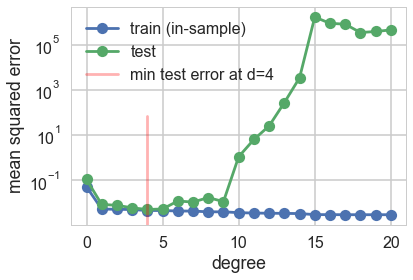

In [22]:
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_test, marker='o', label='test')
plt.axvline(np.argmin(error_test), 0,0.5, color='r', label="min test error at d=%d"%np.argmin(error_test), alpha=0.3)
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")

The graph shows a very interesting structure. The training error decreases with increasing degree of the polynomial. This ought to make sense given what you know now: one can construct an arbitrarily complex polynomial to fit all the training data: indeed one could construct an order 24 polynomial which perfectly interpolates the 24 data points in the training set. You also know that this would do very badly on the test set as it would wiggle like mad to capture all the data points. And this is indeed what we see in the test set error. 

For extremely low degree polynomials like $d=0$ a flat line capturing the mean value of the data or $d=1$ a straight line fitting the data, the polynomial is not curvy enough to capturve the conbtours of the data. We are in the bias/deterministic error regime, where we will always have some difference between the data and the fit since the hypothesis is too simple. But, for degrees higher than 5 or so, the polynomial starts to wiggle too much to capture the training data. The test set error increases as the predictive power of the polynomial goes down thanks to the contortions it must endure to fit the training data.

Thus the test set error first decreases as the model get more expressive, and then, once we exceed a certain level of complexity (here indexed by $d$), it increases. This idea can be used to identify just the right amount of complexity in the model by picking as **the best hypothesis as the one that minimizes test set error** or risk. In our case this happens around $d=4$. (This exact number will depend on the random points chosen into the training and test sets) For complexity lower than this critical value, identified by the red vertical line in the diagram, the hypotheses underfit; for complexity higher, they overfit.

![m:caption](images/complexity-error-plot.png)

Keep in mind that as you see in the plot above this minimum can be shallow: in this case any of the low order polynomials would be "good enough".

## Is this still a test set?

But something should be troubling you about this discussion. We have made no discussion on the error bars on our error estimates, primarily because we have not carried out any resampling to make this possible. 

But secondly we seem to be "visually fitting" a value of $d$. It cant be kosher to use as a test set something you did some fitting on...

We have contaminated our test set. The moment we **use it in the learning process, it is not a test set**.

The answer to the second question is to use a validation set, and leave a separate test set aside. The answer to the first is to use cross-validation, which is a kind of resampling method that uses multiple validation sets!